In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df=pd.read_csv('imdb_cols_for_model.csv')

## Scaling the data

In [3]:
df2=df.copy()

### runtime

In [4]:
df2.runtime.describe()

count    6335.000000
mean      106.546646
std        17.870354
min        63.000000
25%        94.000000
50%       104.000000
75%       115.000000
max       366.000000
Name: runtime, dtype: float64

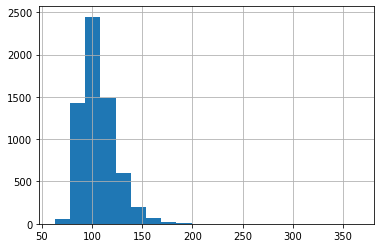

In [5]:
df2.runtime.hist(bins=20)

In [6]:
# there are outliers: longest movie is 366 min (6h!!!)
# we take the log

In [7]:
df2.runtime=df2.runtime.apply(np.log)

In [8]:
df2.runtime.describe()

count    6335.000000
mean        4.656100
std         0.154551
min         4.143135
25%         4.543295
50%         4.644391
75%         4.744932
max         5.902633
Name: runtime, dtype: float64

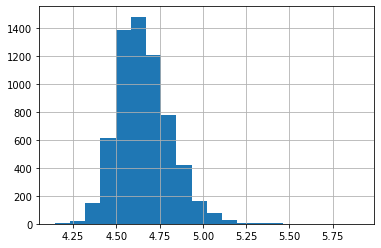

In [9]:
df2.runtime.hist(bins=20)

In [10]:
# we will use minmaxscaler
minmax_cols = ['runtime']

### rating

In [11]:
df2.rating.describe()

count    6335.000000
mean        6.406219
std         0.940703
min         1.400000
25%         5.800000
50%         6.500000
75%         7.100000
max         9.000000
Name: rating, dtype: float64

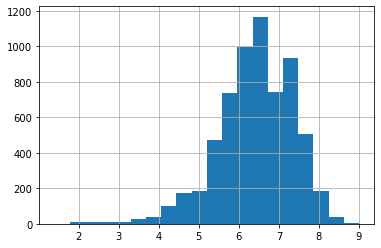

In [12]:
df2.rating.hist(bins=20)

In [13]:
# we divide by 10 to have values between 0 and 1 for the target like for the features

In [14]:
df2.rating=df2.rating/10

### metascore

In [15]:
df2.metascore.describe()

count    6335.000000
mean        0.552513
std         0.175581
min         0.010000
25%         0.430000
50%         0.560000
75%         0.680000
max         1.000000
Name: metascore, dtype: float64

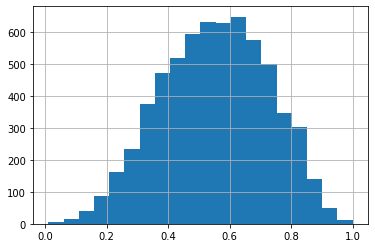

In [16]:
df2.metascore.hist(bins=20)

### votes

In [17]:
df2.votes.describe()

count    6.335000e+03
mean     7.424711e+04
std      1.371200e+05
min      2.711000e+03
25%      7.706500e+03
50%      2.324700e+04
75%      7.790450e+04
max      2.161024e+06
Name: votes, dtype: float64

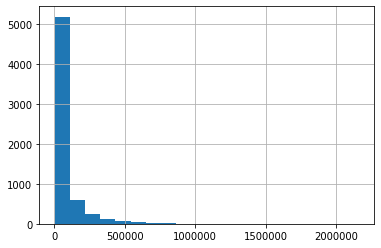

In [18]:
df2.votes.hist(bins=20)

In [19]:
# we need to take the log

In [20]:
df2.votes=df2.votes.apply(np.log)

In [21]:
df2.votes.describe()

count    6335.000000
mean       10.176219
std         1.436236
min         7.905073
25%         8.949819
50%        10.053931
75%        11.263239
max        14.586093
Name: votes, dtype: float64

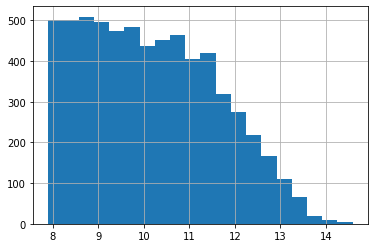

In [22]:
df2.votes.hist(bins=20)

In [23]:
# we will use minmaxscaler
minmax_cols.append('votes')

###  age

In [24]:
df2.age.describe()

count    6335.000000
mean       10.114601
std         5.493757
min         0.000000
25%         5.000000
50%        10.000000
75%        15.000000
max        20.000000
Name: age, dtype: float64

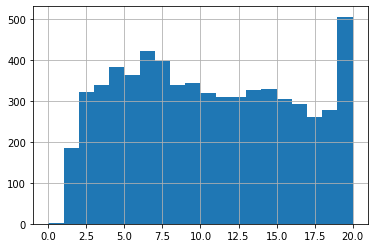

In [25]:
df2.age.hist(bins=20)

In [26]:
# distribution close to uniform 
# we divide by 20 to have values between 0 and 1

In [27]:
df2.age=df2.age/20

### log_cum_worldwide_gross

In [28]:
df2.log_cum_worldwide_gross.describe()

count    6335.000000
mean       15.882624
std         2.739749
min         4.553877
25%        14.021656
50%        16.282271
75%        18.022586
max        21.752099
Name: log_cum_worldwide_gross, dtype: float64

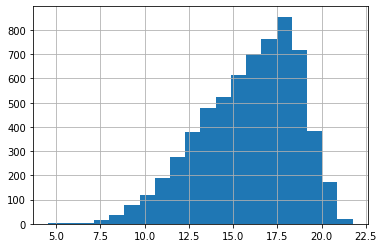

In [29]:
df2.log_cum_worldwide_gross.hist(bins=20)

In [30]:
minmax_cols.append('log_cum_worldwide_gross')

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
scaler = MinMaxScaler()

In [33]:
df2[minmax_cols]=scaler.fit_transform(df2[minmax_cols])

## One Hot Encoding

-  we need to transform the categorical columns into dummies

In [34]:
cols_to_dummies=['writer_category', 'director_category', 'country_category']

In [35]:
df2_ohe=pd.get_dummies(data=df2,prefix=['writer', 'director', 'country'],columns=cols_to_dummies, drop_first=True)

In [36]:
y=df2_ohe.rating

In [37]:
X=df2_ohe.drop('rating', axis=1)

## split data into trainig (80%) and testing (20%) sets

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y, random_state=42)

## Functions to calculate the metrics 

In [39]:
def r_square(y,y_pred):
    from sklearn.metrics import r2_score
    score=r2_score(y,y_pred)
    return score

In [40]:
def mse(y,y_pred):
    from sklearn.metrics import mean_squared_error
    score=mean_squared_error(y,y_pred)
    return score

In [41]:
def mae(y,y_pred):
    from sklearn.metrics import mean_absolute_error
    score=mean_absolute_error(y,y_pred)
    return score

In [42]:
def get_metrics(y_test, y_pred):
    r2_score=r_square(y_test, y_pred)
    mse_score=mse(y_test, y_pred)
    mae_score=mae(y_test, y_pred)
    print("R2:",r2_score)
    print("MSE:",mse_score)
    print("MAE:",mae_score)
    return (r2_score,mse_score,mae_score)

In [231]:
metrics_dict={}
# to record the best metrics for each model tested

# Models:

### Linear Regression Model

In [44]:
from sklearn.linear_model import LinearRegression

#### First test on all the features

In [45]:
linear_model=LinearRegression().fit(X_train,y_train)

In [46]:
y_lin_pred=linear_model.predict(X_test)

In [47]:
get_metrics(y_test,y_lin_pred)

R2: 0.6408786468461327
MSE: 0.0032834499372363596
MAE: 0.04257350315988419


(0.6408786468461327, 0.0032834499372363596, 0.04257350315988419)

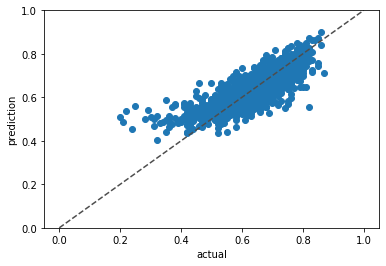

In [48]:
plt.scatter(y_test,y_lin_pred)
plt.xlabel('actual')
plt.ylabel('prediction')
plt.plot([0, 1], [0, 1], ls="--", c=".3")
plt.ylim([0, 1])
plt.show()

- the model is not good: we have too many features
- we reduce the number of features with SFS

#### Feature selection with SFS

In [49]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [50]:
linear=LinearRegression()
sfs_lin_20=sfs(linear, k_features = 20, forward=True, floating = False, scoring='neg_mean_squared_error')

In [51]:
sfs_lin_20_fit=sfs_lin_20.fit(X_train,y_train)
sfs_lin_20_fit.k_feature_idx_

(0, 1, 2, 3, 18, 27, 28, 30, 35, 39, 41, 42, 46, 48, 49, 50, 89, 101, 102, 105)

In [52]:
feat_cols_lin_20=list(sfs_lin_20_fit.k_feature_idx_)

X_train.iloc[:,feat_cols_lin_20]

,runtime,metascore,votes,star_Nicolas Cage,language_English,age,genre_Drama,genre_War,genre_Horror,genre_Sci-Fi,genre_Adventure,genre_Animation,genre_Biography,genre_Fantasy,log_cum_worldwide_gross,k_nudity,director_Tyler Perry,country_Japan,country_South Korea,country_USA
944,0.301048,0.47,0.585245,0,1,0.55,1,0,0,0,0,0,0,1,0.807069,0,0,0,0,1
5184,0.227428,0.64,0.114248,0,0,0.50,1,0,0,0,0,0,0,0,0.453491,0,0,0,0,0
5044,0.295712,0.59,0.126995,0,1,0.65,1,0,0,0,1,0,0,0,0.721620,0,0,0,0,0
12,0.496815,0.85,0.900741,0,1,0.70,1,0,0,0,0,0,0,0,0.868494,0,0,0,0,1
1117,0.268250,0.46,0.559748,0,1,0.45,0,0,0,0,1,0,0,0,0.833650,0,0,0,0,1
4601,0.202714,0.27,0.172864,0,1,0.25,1,0,0,0,0,0,0,0,0.434486,0,0,0,0,1
2899,0.149807,0.65,0.354475,0,1,0.95,0,0,0,0,1,1,0,0,0.808007,0,0,0,0,1
5121,0.221350,0.62,0.120967,0,0,0.35,1,0,0,0,0,0,0,0,0.602758,0,0,0,0,0
642,0.227428,0.94,0.640374,0,1,0.15,1,0,0,0,0,0,0,0,0.792561,0,0,0,0,1
5940,0.316764,0.53,0.039512,0,1,0.45,1,0,0,0,0,0,0,0,0.427099,0,0,0,0,0


In [53]:
linear_model2=LinearRegression().fit(X_train.iloc[:,feat_cols_lin_20],y_train)

In [54]:
y_lin_pred2=linear_model2.predict(X_test.iloc[:,feat_cols_lin_20])

In [55]:
get_metrics(y_test,y_lin_pred2)

R2: 0.6337382491339387
MSE: 0.003348734661227419
MAE: 0.0427515174313653


(0.6337382491339387, 0.003348734661227419, 0.0427515174313653)

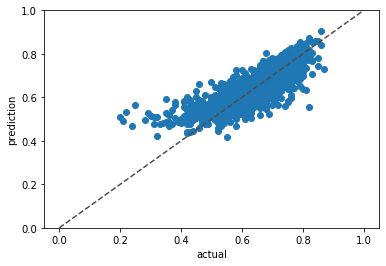

In [57]:
plt.scatter(y_test,y_lin_pred2)
plt.xlabel('actual')
plt.ylabel('prediction')
plt.plot([0, 1], [0, 1], ls="--", c=".3")
plt.ylim([0, 1])
plt.show()

- now with the selection of 10 features:

In [58]:
linear=LinearRegression()
sfs_lin_10=sfs(linear, k_features = 10, forward=True, floating = False, scoring='neg_mean_squared_error')

sfs_lin_10_fit=sfs_lin_10.fit(X_train,y_train)
sfs_lin_10_fit.k_feature_idx_

(0, 1, 2, 18, 28, 35, 42, 46, 49, 105)

In [59]:
feat_cols_lin_10=list(sfs_lin_10_fit.k_feature_idx_)

X_train.iloc[:,feat_cols_lin_10].head()

,runtime,metascore,votes,language_English,genre_Drama,genre_Horror,genre_Animation,genre_Biography,log_cum_worldwide_gross,country_USA
944,0.301048,0.47,0.585245,1,1,0,0,0,0.807069,1
5184,0.227428,0.64,0.114248,0,1,0,0,0,0.453491,0
5044,0.295712,0.59,0.126995,1,1,0,0,0,0.721620,0
12,0.496815,0.85,0.900741,1,1,0,0,0,0.868494,1
1117,0.268250,0.46,0.559748,1,0,0,0,0,0.833650,1


In [60]:
linear_model3=LinearRegression().fit(X_train.iloc[:,feat_cols_lin_10],y_train)

In [61]:
y_lin_pred3=linear_model3.predict(X_test.iloc[:,feat_cols_lin_10])

In [62]:
get_metrics(y_test,y_lin_pred3)

R2: 0.6235669112519535
MSE: 0.0034417312999316225
MAE: 0.0434146596599259


(0.6235669112519535, 0.0034417312999316225, 0.0434146596599259)

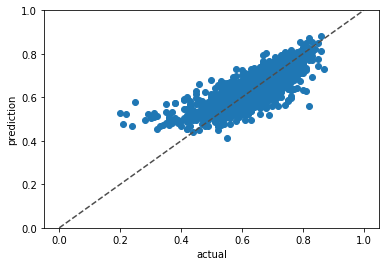

In [63]:
plt.scatter(y_test,y_lin_pred3)
plt.xlabel('actual')
plt.ylabel('prediction')
plt.plot([0, 1], [0, 1], ls="--", c=".3")
plt.ylim([0, 1])
plt.show()

In [64]:
# the low rating scores (~0.2) are not well predicted (pred~0.5)

#### Feature selection with PCA

In [65]:
from sklearn.decomposition import PCA

In [73]:
pca=PCA(0.85)
principal_components=pca.fit_transform(X)

In [74]:
principal_components.shape

(6335, 32)

In [81]:
pca.explained_variance_

array([0.41665474, 0.31563015, 0.25419251, 0.18375839, 0.16640378,
       0.14526585, 0.13665621, 0.1224579 , 0.10443119, 0.09520602,
       0.09247942, 0.09022452, 0.07890948, 0.07511533, 0.07088388,
       0.06742102, 0.06264664, 0.06062861, 0.05796121, 0.05543702,
       0.05181365, 0.04926748, 0.04546855, 0.04253252, 0.04183705,
       0.0395381 , 0.03768581, 0.03657806, 0.03449927, 0.03327062,
       0.0326284 , 0.02976288])

In [75]:
cols=['PC_{}'.format(i) for i in range(1,principal_components.shape[1]+1)]

In [78]:
X_pca=pd.DataFrame(data=principal_components,columns=cols)

In [80]:
X_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29,PC_30,PC_31,PC_32
0,-0.172032,0.610661,-0.526448,-0.909095,0.629809,0.113965,0.180305,0.140320,-0.376588,0.004405,...,0.089963,-0.081146,0.094060,0.179592,-0.104377,0.578811,0.563915,-0.162846,0.150872,0.219051
1,-0.886966,0.910353,0.479534,-0.748250,-0.534149,0.786751,-0.054961,-0.394529,-0.214745,0.141956,...,0.650943,-0.143194,-0.160126,-0.328799,0.010978,0.130950,-0.231346,-0.022483,0.019882,-0.379653
2,0.436028,0.285110,0.403901,-0.562096,-0.614860,-0.314759,-0.291935,0.242149,0.249545,0.366692,...,0.219253,-0.190625,-0.146376,-0.090045,-0.063011,-0.039944,0.170274,-0.062556,0.185384,-0.245680
3,0.441292,0.294658,0.404009,-0.569151,-0.625308,-0.326069,-0.289004,0.233148,0.258092,0.356102,...,0.209396,-0.187172,-0.138741,-0.088270,-0.077503,-0.035962,0.177729,-0.063295,0.183711,-0.255854
4,-0.046174,1.130378,0.567809,0.236566,0.014253,0.024961,0.953256,-0.098157,0.212130,-0.657012,...,0.047097,-0.167610,0.243867,0.017733,-0.451611,-0.082917,0.168845,0.056362,-0.015347,-0.189919


In [82]:
X_pca_train, X_pca_test, y_pca_train, y_pca_test=train_test_split(X_pca,
                                                 y, random_state=42)

In [83]:
linear_model4=LinearRegression().fit(X_pca_train,y_pca_train)

In [84]:
y_lin_pred4=linear_model4.predict(X_pca_test)

In [112]:
get_metrics(y_pca_test,y_lin_pred4)

R2: 0.5180408729899342
MSE: 0.0044065568684067274
MAE: 0.04827766765654339


(0.5180408729899342, 0.0044065568684067274, 0.04827766765654339)

In [95]:
# pca does not make it better

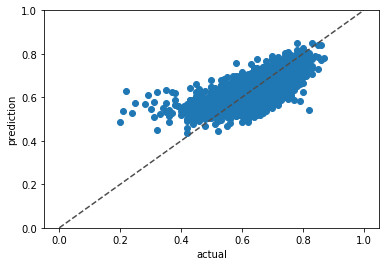

In [113]:
plt.scatter(y_pca_test,y_lin_pred4)
plt.xlabel('actual')
plt.ylabel('prediction')
plt.plot([0, 1], [0, 1], ls="--", c=".3")
plt.ylim([0, 1])
plt.show()

In [232]:
metrics_dict['LINEAR']=get_metrics(y_test,y_lin_pred2)

R2: 0.6337382491339387
MSE: 0.003348734661227419
MAE: 0.0427515174313653


### K-Nearest-Neighbors

In [89]:
from sklearn.neighbors import KNeighborsRegressor

#### First test on all the features

In [90]:
neigh = KNeighborsRegressor()

In [91]:
neigh.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [92]:
y_knn_pred=neigh.predict(X_test)

In [93]:
get_metrics(y_test,y_knn_pred)

R2: 0.37325357740824816
MSE: 0.005730348484848485
MAE: 0.05655808080808081


(0.37325357740824816, 0.005730348484848485, 0.05655808080808081)

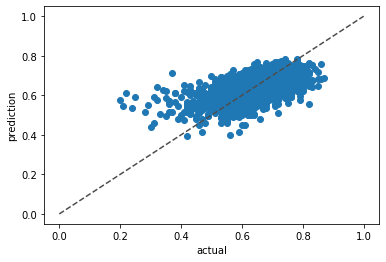

In [94]:
plt.scatter(y_test,y_knn_pred)
plt.xlabel('actual')
plt.ylabel('prediction')
plt.plot([0, 1], [0, 1], ls="--", c=".3")
plt.show()

#### SFS

In [96]:
neighbor=KNeighborsRegressor()
sfs_knn_20=sfs(neighbor, k_features = 20, forward=True, floating = False, scoring='neg_mean_squared_error')

In [97]:
sfs_knn_20_fit=sfs_knn_20.fit(X_train,y_train)
sfs_knn_20_fit.k_feature_idx_

(0, 1, 2, 3, 10, 13, 18, 33, 34, 35, 38, 42, 46, 49, 69, 70, 83, 88, 89, 102)

In [98]:
feat_cols_knn_20=list(sfs_knn_20_fit.k_feature_idx_)

X_train.iloc[:,feat_cols_knn_20].head()

,runtime,metascore,votes,star_Nicolas Cage,star_Mark Wahlberg,star_Owen Wilson,language_English,genre_Adult,genre_Music,genre_Horror,genre_Action,genre_Animation,genre_Biography,log_cum_worldwide_gross,writer_Olivier Assayas,writer_Paul Laverty,director_Ron Howard,director_Tim Burton,director_Tyler Perry,country_South Korea
944,0.301048,0.47,0.585245,0,0,0,1,0,0,0,0,0,0,0.807069,0,0,0,0,0,0
5184,0.227428,0.64,0.114248,0,0,0,0,0,0,0,0,0,0,0.453491,0,0,0,0,0,0
5044,0.295712,0.59,0.126995,0,0,0,1,0,0,0,0,0,0,0.721620,0,0,0,0,0,0
12,0.496815,0.85,0.900741,0,0,0,1,0,0,0,0,0,0,0.868494,0,0,0,0,0,0
1117,0.268250,0.46,0.559748,0,0,0,1,0,0,0,1,0,0,0.833650,0,0,0,0,0,0


In [99]:
neigh20 = KNeighborsRegressor()

In [100]:
neigh20.fit(X_train.iloc[:,feat_cols_knn_20],y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [101]:
y_knn_pred2=neigh20.predict(X_test.iloc[:,feat_cols_knn_20])

In [102]:
get_metrics(y_test,y_knn_pred2)

R2: 0.5745046433261175
MSE: 0.00389030808080808
MAE: 0.04595959595959595


(0.5745046433261175, 0.00389030808080808, 0.04595959595959595)

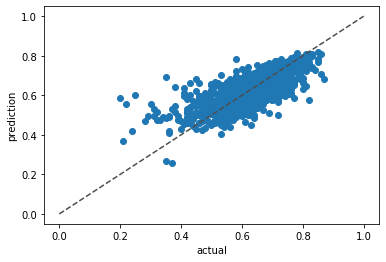

In [103]:
plt.scatter(y_test,y_knn_pred2)
plt.xlabel('actual')
plt.ylabel('prediction')
plt.plot([0, 1], [0, 1], ls="--", c=".3")
plt.show()

In [104]:
neighbor=KNeighborsRegressor()
sfs_knn_10=sfs(neighbor, k_features = 10, forward=True, floating = False, scoring='neg_mean_squared_error')

In [105]:
sfs_knn_10_fit=sfs_knn_10.fit(X_train,y_train)
sfs_knn_10_fit.k_feature_idx_

(0, 1, 2, 3, 18, 35, 42, 46, 49, 102)

In [106]:
feat_cols_knn_10=list(sfs_knn_10_fit.k_feature_idx_)

X_train.iloc[:,feat_cols_knn_10].head()

,runtime,metascore,votes,star_Nicolas Cage,language_English,genre_Horror,genre_Animation,genre_Biography,log_cum_worldwide_gross,country_South Korea
944,0.301048,0.47,0.585245,0,1,0,0,0,0.807069,0
5184,0.227428,0.64,0.114248,0,0,0,0,0,0.453491,0
5044,0.295712,0.59,0.126995,0,1,0,0,0,0.721620,0
12,0.496815,0.85,0.900741,0,1,0,0,0,0.868494,0
1117,0.268250,0.46,0.559748,0,1,0,0,0,0.833650,0


In [107]:
neigh10 = KNeighborsRegressor()

In [108]:
neigh10.fit(X_train.iloc[:,feat_cols_knn_10],y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [109]:
y_knn_pred3=neigh10.predict(X_test.iloc[:,feat_cols_knn_10])

In [110]:
get_metrics(y_test,y_knn_pred3)

R2: 0.5943945423470677
MSE: 0.0037084545454545447
MAE: 0.044992424242424243


(0.5943945423470677, 0.0037084545454545447, 0.044992424242424243)

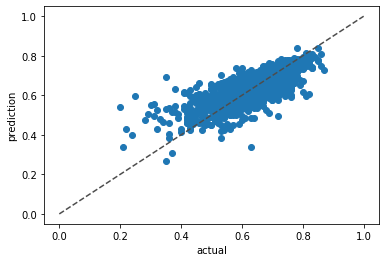

In [111]:
plt.scatter(y_test,y_knn_pred3)
plt.xlabel('actual')
plt.ylabel('prediction')
plt.plot([0, 1], [0, 1], ls="--", c=".3")
plt.show()

#### PCA

In [114]:
neigh4 = KNeighborsRegressor()

In [115]:
neigh4.fit(X_pca_train,y_pca_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [116]:
y_knn_pred4=neigh4.predict(X_pca_test)

In [117]:
get_metrics(y_pca_test,y_knn_pred4)

R2: 0.3227546555709322
MSE: 0.0061920606060606054
MAE: 0.058924242424242414


(0.3227546555709322, 0.0061920606060606054, 0.058924242424242414)

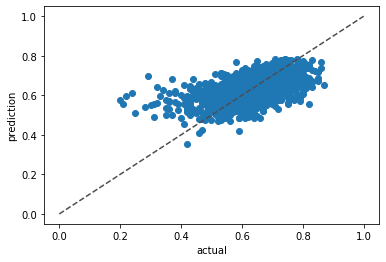

In [119]:
plt.scatter(y_pca_test,y_knn_pred4)
plt.xlabel('actual')
plt.ylabel('prediction')
plt.plot([0, 1], [0, 1], ls="--", c=".3")
plt.show()

In [233]:
metrics_dict['KNN']=get_metrics(y_test,y_knn_pred3)

R2: 0.5943945423470677
MSE: 0.0037084545454545447
MAE: 0.044992424242424243


### Decision Tree Regressor

In [121]:
from sklearn.tree import DecisionTreeRegressor

In [122]:
regressor = DecisionTreeRegressor()

In [123]:
regressor.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [124]:
y_dt_pred=regressor.predict(X_test)

In [125]:
get_metrics(y_test,y_dt_pred)

R2: 0.34768290182908856
MSE: 0.005964141414141413
MAE: 0.05784090909090908


(0.34768290182908856, 0.005964141414141413, 0.05784090909090908)

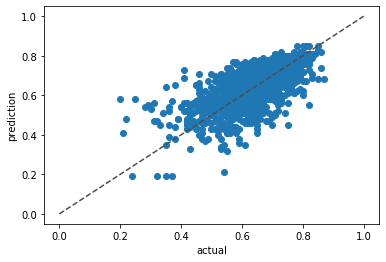

In [126]:
plt.scatter(y_test,y_dt_pred)
plt.xlabel('actual')
plt.ylabel('prediction')
plt.plot([0, 1], [0, 1], ls="--", c=".3")
plt.show()


In [187]:
pd.DataFrame(regressor.feature_importances_,X.columns).sort_values(by=[0],ascending=False)[:10]

,0
metascore,0.544624
votes,0.116219
runtime,0.079551
log_cum_worldwide_gross,0.061261
age,0.036613
genre_Horror,0.015885
genre_Drama,0.015734
country_USA,0.008026
language_English,0.006707
genre_Action,0.005591


#### hyperparameter tuning with RandomizedSearchCV

In [127]:
from scipy.stats import uniform, randint

In [128]:
from sklearn.model_selection import RandomizedSearchCV

In [168]:
params_dt={'max_depth': randint(3,25),
          'max_features': randint(10,40)}

In [169]:
dt_model=DecisionTreeRegressor()

In [170]:
search=RandomizedSearchCV(dt_model, param_distributions=params_dt, random_state=42, n_iter=200, cv=3, n_jobs=-1 ,return_train_score=True)

In [171]:
search.fit(X_train,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DecisionTreeRegressor(criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort=False,
                                                   random_state=None,
                                                   splitter='best'),
                   iid='warn', n_iter=200, n_jobs=-1,
                   param_dis

In [172]:
search.best_params_

{'max_depth': 7, 'max_features': 35}

In [173]:
best_dt_model=search_rd.best_estimator_.fit(X_train,y_train)

In [174]:
y_dt_pred2=best_dt_model.predict(X_test)

In [175]:
get_metrics(y_test,y_dt_pred2)

R2: 0.5277759025780325
MSE: 0.004317549400570805
MAE: 0.048771374110045486


(0.5277759025780325, 0.004317549400570805, 0.048771374110045486)

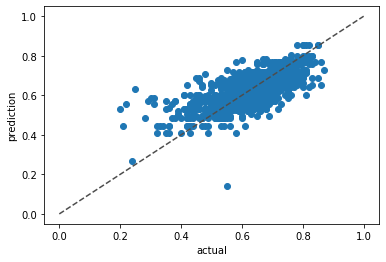

In [176]:
plt.scatter(y_test,y_dt_pred2)
plt.xlabel('actual')
plt.ylabel('prediction')
plt.plot([0, 1], [0, 1], ls="--", c=".3")
plt.show()


In [177]:
# with the decision tree, the metrics are not better than with the basic linear regression, but it is able to better predict some of the low rating

In [178]:
pd.DataFrame(best_dt_model.feature_importances_,X.columns).sort_values(by=[0],ascending=False)[:10]

,0
metascore,0.755817
runtime,0.095996
votes,0.046399
log_cum_worldwide_gross,0.018785
genre_Drama,0.017357
age,0.017191
genre_Horror,0.012209
genre_Sport,0.007832
language_English,0.003776
genre_History,0.003211


In [234]:
metrics_dict['DT']=get_metrics(y_test,y_dt_pred2)

R2: 0.5277759025780325
MSE: 0.004317549400570805
MAE: 0.048771374110045486


### Random Forest

In [180]:
from sklearn.ensemble import RandomForestRegressor


In [181]:
regressor_rf = RandomForestRegressor()

In [182]:
regressor_rf.fit(X_train, y_train)

C:\Users\Marie\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [183]:
y_rf_pred = regressor_rf.predict(X_test)

In [184]:
get_metrics(y_test,y_rf_pred)

R2: 0.6163435433436883
MSE: 0.003507774621212121
MAE: 0.04339330808080808


(0.6163435433436883, 0.003507774621212121, 0.04339330808080808)

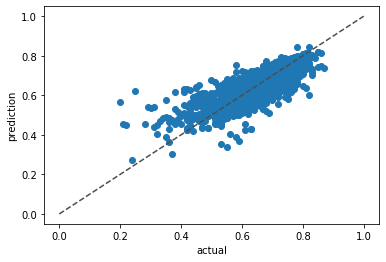

In [185]:
plt.scatter(y_test,y_rf_pred)
plt.xlabel('actual')
plt.ylabel('prediction')
plt.plot([0, 1], [0, 1], ls="--", c=".3")
plt.show()

In [186]:
pd.DataFrame(regressor_rf.feature_importances_,X.columns).sort_values(by=[0],ascending=False)[:10]

,0
metascore,0.539812
votes,0.111456
runtime,0.081930
log_cum_worldwide_gross,0.060737
age,0.037315
genre_Horror,0.016515
genre_Drama,0.014849
country_USA,0.010299
language_English,0.007774
genre_Action,0.005811


In [202]:
params_rf={'max_depth': randint(3,25),
          'max_features': randint(10,40)}

In [203]:
rf_model=RandomForestRegressor()

In [204]:
search_rf=RandomizedSearchCV(rf_model, param_distributions=params_rf, random_state=42, n_iter=200, cv=3, n_jobs=-1 ,return_train_score=True)

In [205]:
search_rf.fit(X_train,y_train)

C:\Users\Marie\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...e

In [206]:
search_rf.best_params_

{'max_depth': 14, 'max_features': 39}

In [207]:
best_rf_model=search_rf.best_estimator_.fit(X_train,y_train)

In [208]:
y_rf_pred2=best_rf_model.predict(X_test)

In [209]:
get_metrics(y_test,y_rf_pred2)

R2: 0.6307823057429212
MSE: 0.0033757608796810812
MAE: 0.04266737224701018


(0.6307823057429212, 0.0033757608796810812, 0.04266737224701018)

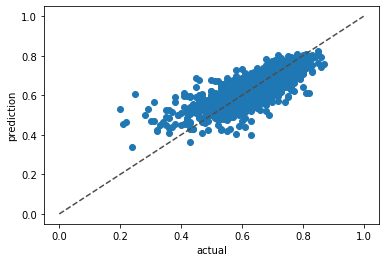

In [210]:
plt.scatter(y_test,y_rf_pred2)
plt.xlabel('actual')
plt.ylabel('prediction')
plt.plot([0, 1], [0, 1], ls="--", c=".3")
plt.show()


In [235]:
metrics_dict['RF']=get_metrics(y_test,y_rf_pred2)

R2: 0.6307823057429212
MSE: 0.0033757608796810812
MAE: 0.04266737224701018


## Comparison of the models

In [236]:
metrics_df=pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['R2','MSE','MAE'])

In [237]:
round(metrics_df,3)

,R2,MSE,MAE
LINEAR,0.634,0.003,0.043
KNN,0.594,0.004,0.045
DT,0.528,0.004,0.049
RF,0.631,0.003,0.043


In [221]:
# linear regression and random forest are the best models here